<a href="https://colab.research.google.com/github/fazamumtaz/compfest-dsa/blob/main/kaggle_dsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb

# Load Dataset

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/dsa_academy_compfest/"
train = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")

In [ ]:
train.head()

,ID,date,cluster_id,electricity_consumption,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration
0,cluster_1_2014-01-01,2014-01-01,cluster_1,358.032,10.8,4.2,5.5,0.4,53.003333,29787.533333,40.6,79.2,186.000000,1.176667,0.483333
1,cluster_2_2014-01-01,2014-01-01,cluster_2,548.247,12.2,4.3,8.6,-0.4,8195.656667,30650.350000,36.0,81.7,170.591118,3.383333,0.736667
2,cluster_3_2014-01-01,2014-01-01,cluster_3,758.303,12.9,-0.8,10.1,-4.9,16305.260000,31547.686667,20.9,44.3,159.467752,3.880000,0.716667
3,cluster_4_2014-01-01,2014-01-01,cluster_4,1072.077,10.8,4.7,6.7,0.6,9224.803333,30769.220000,34.7,82.8,184.339753,3.153333,0.676667
4,cluster_1_2014-01-02,2014-01-02,cluster_1,386.908,10.7,7.0,6.6,3.3,22372.000000,29850.226667,34.3,75.2,210.333465,3.640000,0.780000


## Cek Dataset

In [ ]:
print(f"Ukuran DataFrame train: {train.shape}")
print(f"Ukuran DataFrame test: {test.shape}")
train.info()

Ukuran DataFrame train: (11688, 15)
Ukuran DataFrame test: (3400, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           11688 non-null  object 
 1   date                         11688 non-null  object 
 2   cluster_id                   11688 non-null  object 
 3   electricity_consumption      11688 non-null  float64
 4   temperature_2m_max           11688 non-null  float64
 5   temperature_2m_min           11688 non-null  float64
 6   apparent_temperature_max     11688 non-null  float64
 7   apparent_temperature_min     11688 non-null  float64
 8   sunshine_duration            11688 non-null  float64
 9   daylight_duration            11688 non-null  float64
 10  wind_speed_10m_max           11688 non-null  float64
 11  wind_gusts_10m_max           11688 non-null  float64
 12  wind

## Check Any Missing Value

In [ ]:
test.isnull().sum()

,0
ID,0
date,0
cluster_id,0
temperature_2m_max,0
temperature_2m_min,0
apparent_temperature_max,0
apparent_temperature_min,0
sunshine_duration,0
daylight_duration,0
wind_speed_10m_max,0


# Proses Data

## Merubah Kolom date ke datetime

In [ ]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## Ekstraksi dari kolom date

In [ ]:
for df in [train, test]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6])
    df['dayofyear'] = df['date'].dt.dayofyear

## Another column

In [ ]:
train['mid_temperature_2m'] = (train['temperature_2m_max'] - train['temperature_2m_min'])
test['mid_temperature_2m'] = (test['temperature_2m_max'] + test['temperature_2m_min'])

In [ ]:
train['apparent_temperature_range'] = train['apparent_temperature_max'] - train['apparent_temperature_min']
test['apparent_temperature_range'] = test['apparent_temperature_max'] - test['apparent_temperature_min']

In [ ]:
train.loc[train['wind_gusts_10m_max'] > 80, 'wind_gusts_10m_max'] = 80
train.loc[train['wind_speed_10m_max'] > 70, 'wind_speed_10m_max'] = 70

## One-Hot Encoding for cluster_id

In [ ]:
train = pd.get_dummies(train, columns=['cluster_id'], drop_first=True)
test = pd.get_dummies(test, columns=['cluster_id'], drop_first=True)

In [ ]:
print(train.columns)
print(test.columns)

Index(['ID', 'date', 'electricity_consumption', 'temperature_2m_max',
       'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'sunshine_duration', 'daylight_duration',
       'wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration', 'year', 'month', 'day', 'dayofweek',
       'is_weekend', 'dayofyear', 'mid_temperature_2m',
       'apparent_temperature_range', 'cluster_id_cluster_2',
       'cluster_id_cluster_3', 'cluster_id_cluster_4'],
      dtype='object')
Index(['ID', 'date', 'temperature_2m_max', 'temperature_2m_min',
       'apparent_temperature_max', 'apparent_temperature_min',
       'sunshine_duration', 'daylight_duration', 'wind_speed_10m_max',
       'wind_gusts_10m_max', 'wind_direction_10m_dominant',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'year',
       'month', 'day', 'dayofweek', 'is_weekend', 'dayofyear',
       'mid_tempe

In [ ]:
train.head()

,ID,date,electricity_consumption,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunshine_duration,daylight_duration,wind_speed_10m_max,...,month,day,dayofweek,is_weekend,dayofyear,mid_temperature_2m,apparent_temperature_range,cluster_id_cluster_2,cluster_id_cluster_3,cluster_id_cluster_4
0,cluster_1_2014-01-01,2014-01-01,358.032,10.8,4.2,5.5,0.4,53.003333,29787.533333,40.6,...,1,1,2,False,1,6.6,5.1,False,False,False
1,cluster_2_2014-01-01,2014-01-01,548.247,12.2,4.3,8.6,-0.4,8195.656667,30650.350000,36.0,...,1,1,2,False,1,7.9,9.0,True,False,False
2,cluster_3_2014-01-01,2014-01-01,758.303,12.9,-0.8,10.1,-4.9,16305.260000,31547.686667,20.9,...,1,1,2,False,1,13.7,15.0,False,True,False
3,cluster_4_2014-01-01,2014-01-01,1072.077,10.8,4.7,6.7,0.6,9224.803333,30769.220000,34.7,...,1,1,2,False,1,6.1,6.1,False,False,True
4,cluster_1_2014-01-02,2014-01-02,386.908,10.7,7.0,6.6,3.3,22372.000000,29850.226667,34.3,...,1,2,3,False,2,3.7,3.3,False,False,False


# Visualisasi Data

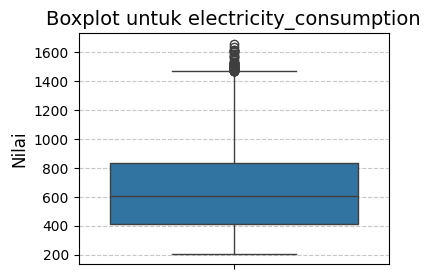

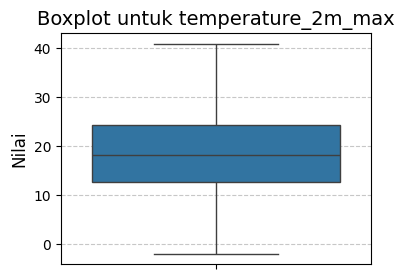

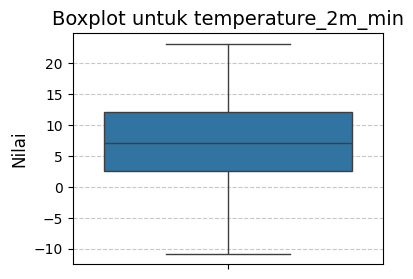

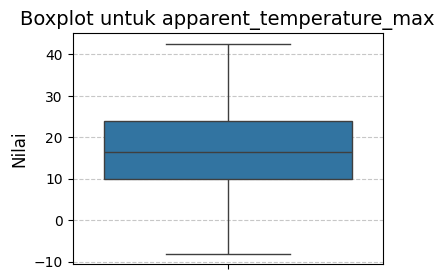

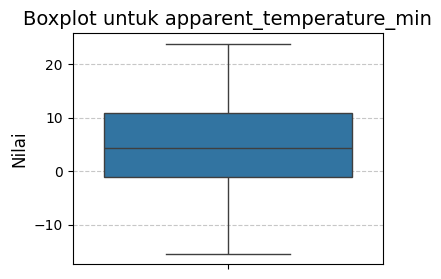

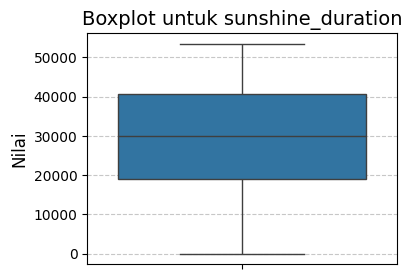

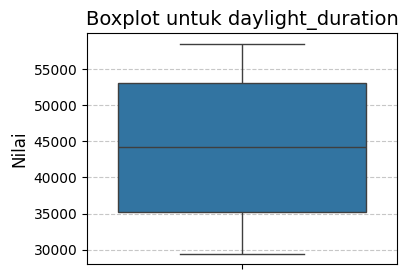

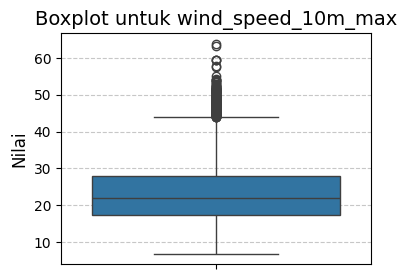

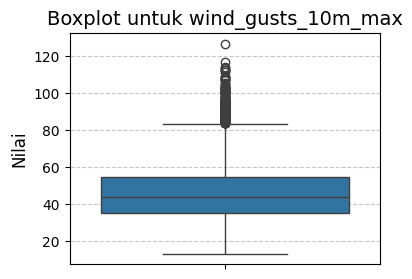

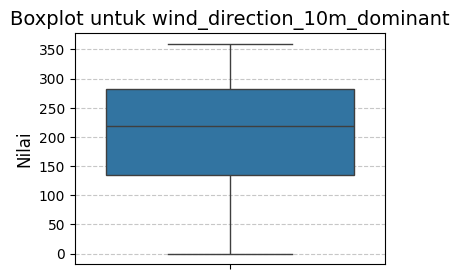

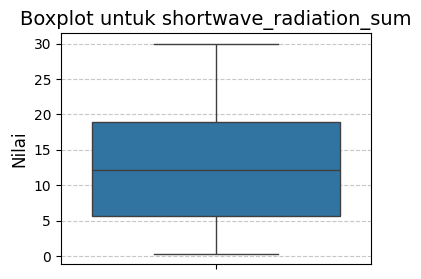

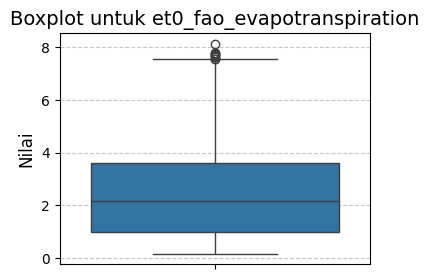

In [ ]:
bak = ['electricity_consumption',
       'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'sunshine_duration', 'daylight_duration',
       'wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration']
for col in bak:
    plt.figure(figsize=(4, 3)) # Atur ukuran plot biar bagus pas dilihat 📏
    sns.boxplot(y=train[col]) # Bikin boxplotnya, pake sumbu Y untuk nilai kolom
    plt.title(f'Boxplot untuk {col}', fontsize=14) # Judul plot sesuai nama kolom 🏷️
    plt.ylabel('Nilai', fontsize=12) # Label sumbu Y
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Tambahin grid biar rapih dan mudah dibaca 📊
    plt.show() # Tampilkan plotnya! ✨

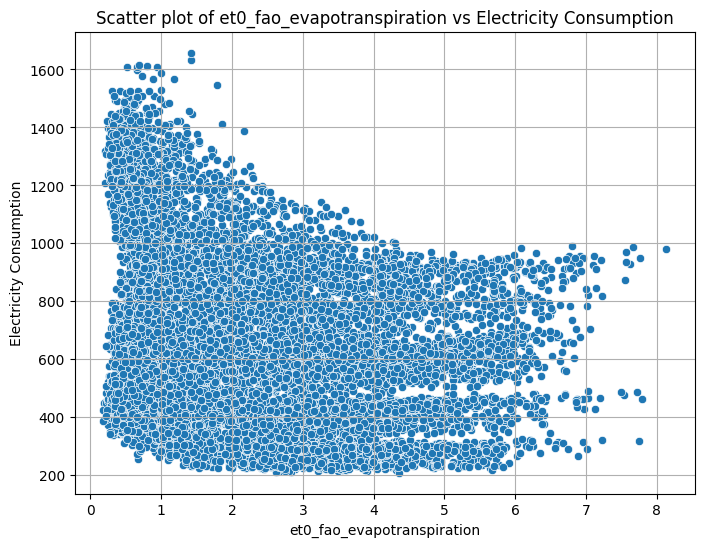

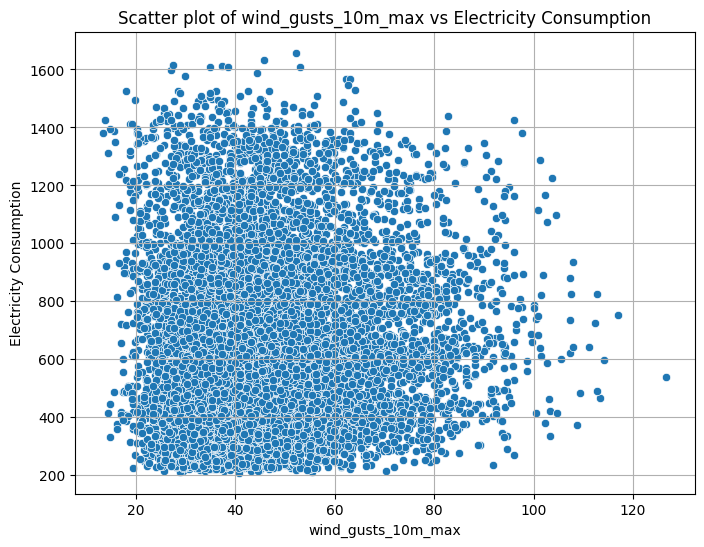

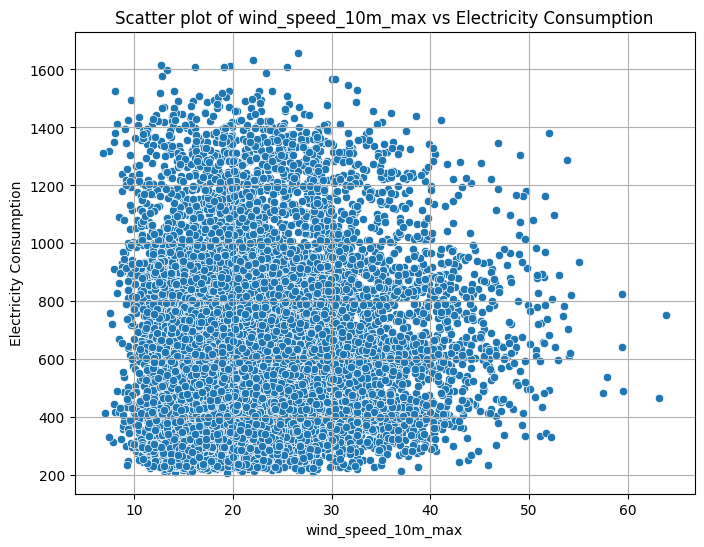

In [ ]:
# prompt: plot a scatter plot using sns for the correlation of each these columns: et0_fao_evapotranspiration
# wind_gusts_10m_max
# wind_speed_10m_max
# to electricity consumption column

cols_to_plot = ['et0_fao_evapotranspiration', 'wind_gusts_10m_max', 'wind_speed_10m_max']

for col in cols_to_plot:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=train, x=col, y='electricity_consumption')
    plt.title(f'Scatter plot of {col} vs Electricity Consumption')
    plt.xlabel(col)
    plt.ylabel('Electricity Consumption')
    plt.grid(True)
    plt.show()

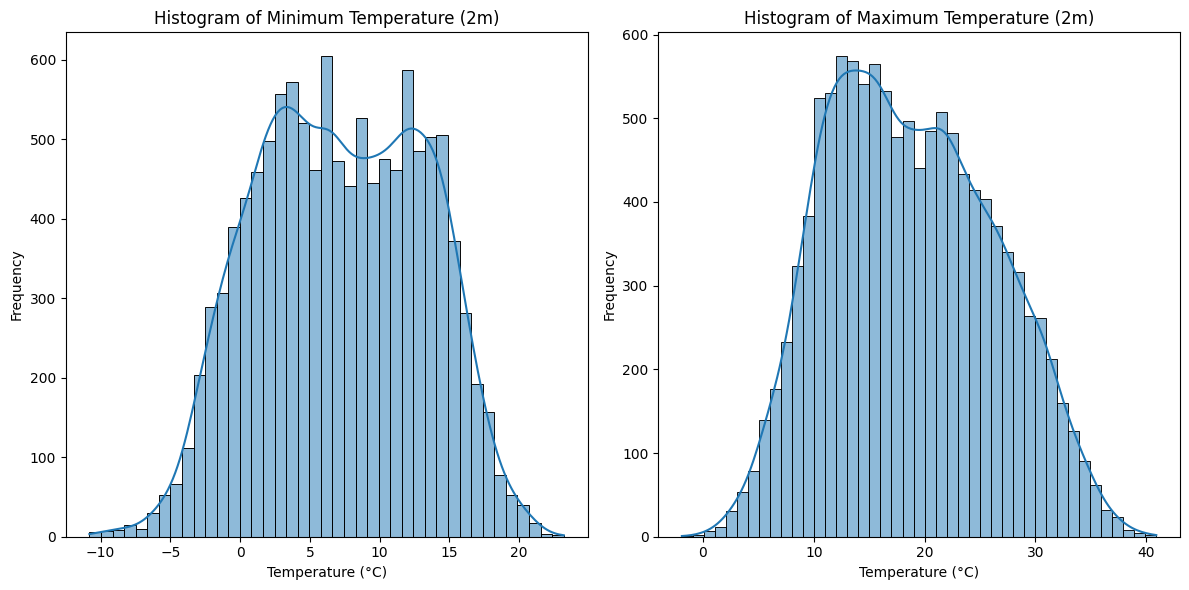

In [ ]:
# prompt: plot temperature 2m min and max each to a histogram

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['temperature_2m_min'], kde=True)
plt.title('Histogram of Minimum Temperature (2m)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(train['temperature_2m_max'], kde=True)
plt.title('Histogram of Maximum Temperature (2m)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

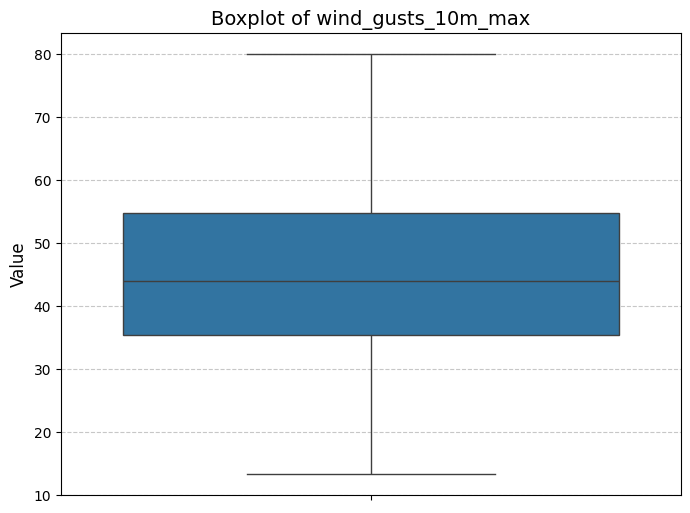

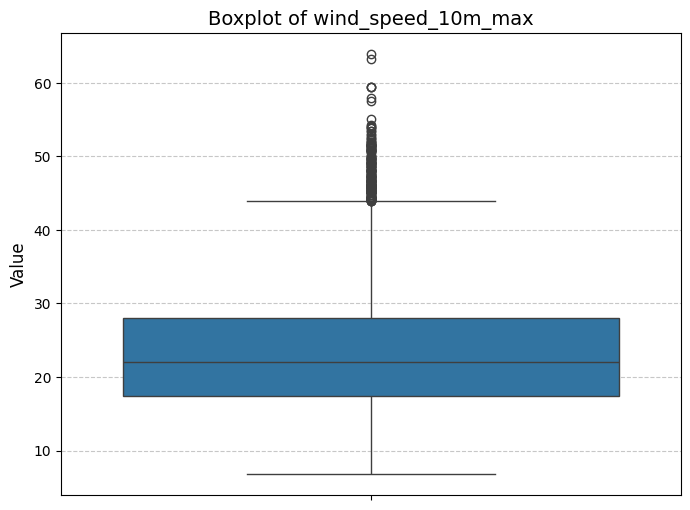

In [ ]:
# prompt: plot boxplot wind gusts and speed features

# Define the features to plot
features_to_plot = ['wind_gusts_10m_max', 'wind_speed_10m_max']

# Create a boxplot for each feature
for feature in features_to_plot:
    plt.figure(figsize=(8, 6)) # Set figure size
    sns.boxplot(y=train[feature]) # Create boxplot using seaborn
    plt.title(f'Boxplot of {feature}', fontsize=14) # Set title
    plt.ylabel('Value', fontsize=12) # Set y-axis label
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add grid
    plt.show() # Display the plot

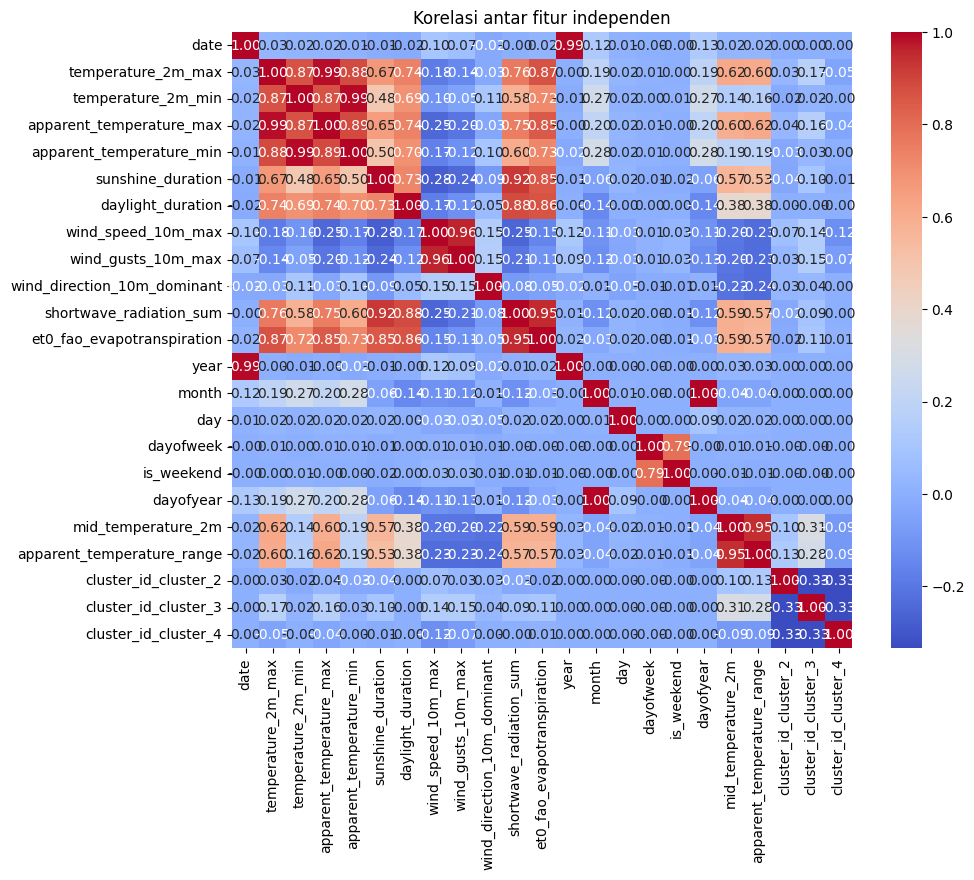

In [ ]:
check_corr = train.drop(['electricity_consumption', 'ID'], axis=1)
correlation_matrix = check_corr.corr()
# print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi antar fitur independen')
plt.show()

In [ ]:
plt.figure(figsize=(4, 3)) # Ukuran plot
sns.boxplot(x='is_weekend', y='electricity_consumption', data=train) # Buat box plot
plt.title('Konsumsi Listrik Harian Berdasarkan Akhir Pekan/Hari Kerja') # Judul
plt.xlabel('Apakah Akhir Pekan?') # Label sumbu X
plt.ylabel('Konsumsi Listrik (GWh)') # Label sumbu Y
plt.xticks(ticks=[0, 1], labels=['Hari Kerja (False)', 'Akhir Pekan (True)']) # Ubah label sumbu X agar lebih mudah dibaca
plt.grid(True, linestyle='--', alpha=0.7) # Tambahkan grid
plt.show() # Tampilkan plot

NameError: name 'plt' is not defined

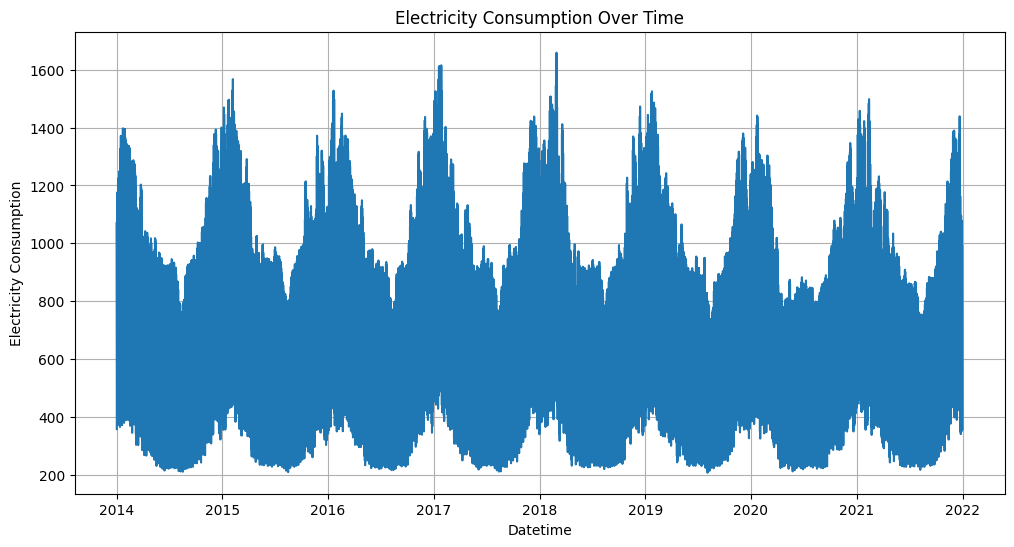

In [ ]:
# prompt: plot electricityconsumption in y and datetime in x

plt.figure(figsize=(12, 6))
plt.plot(train['date'], train['electricity_consumption'])
plt.xlabel('Datetime')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Over Time')
plt.grid(True)
plt.show()

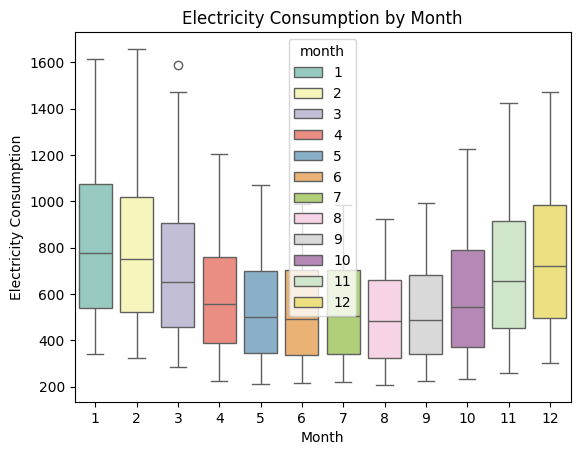

In [ ]:
sns.boxplot(data=train, x='month', y='electricity_consumption', palette='Set3', hue='month')
plt.title('Electricity Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Consumption')
plt.show()

# Setup dan Training

In [ ]:
from sklearn.model_selection import train_test_split

FEATURES = [
      'temperature_2m_max',
       'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'sunshine_duration',
        'daylight_duration',
       'wind_speed_10m_max',
       'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'shortwave_radiation_sum',
       'et0_fao_evapotranspiration',
       'year', 'month', 'day', 'dayofweek',
       'is_weekend', 'dayofyear', 'mid_temperature_2m',
       'apparent_temperature_range', 'cluster_id_cluster_2',
       'cluster_id_cluster_3', 'cluster_id_cluster_4']

TARGET = ['electricity_consumption']

train_mod = train[FEATURES]
test_mod = test.reindex(columns=train_mod.columns, fill_value=0)
y = train[TARGET]

X_train, X_val, y_train, y_val = train_test_split(train_mod, y, test_size=0.2, random_state=42)


In [ ]:
reg = xgb.XGBRegressor(n_estimators=2000,
                       early_stopping_rounds=50,
                       learning_rate=0.01,
                       random_state=42,
                       objective='reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=500)

[0]	validation_0-rmse:283.91705	validation_1-rmse:288.75085
[500]	validation_0-rmse:21.29232	validation_1-rmse:27.76227
[1000]	validation_0-rmse:16.10047	validation_1-rmse:24.15312
[1500]	validation_0-rmse:13.64567	validation_1-rmse:23.02565
[1999]	validation_0-rmse:11.96950	validation_1-rmse:22.44438


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Feature Importance

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])

<Axes: title={'center': 'Feature Importance'}>

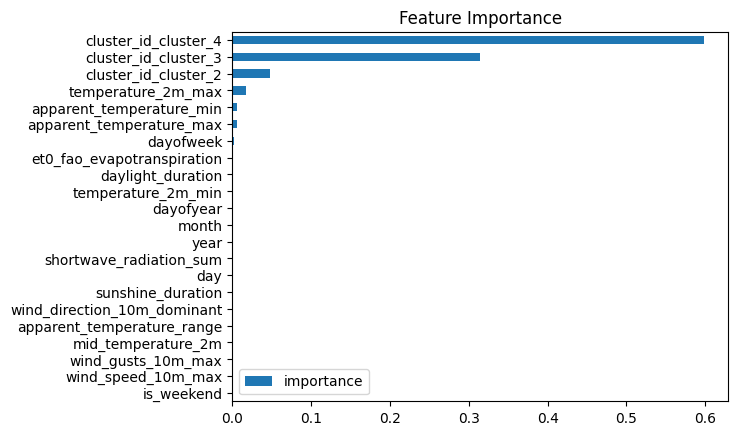

In [ ]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

# Buat File Submission

In [ ]:
# Prediksi di validation set
y_pred = reg.predict(X_val)

# Hitung RMSE di validation set
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse}")

# # Prediksi di test set
# test_preds = reg.predict(test_mod)

# # Buat submission file
# submission = pd.DataFrame({
#     'ID': test['ID'],
#     'electricity_consumption': test_preds
# })

# submission.to_csv('submission1.csv', index=False)
# print("Submission file created!")

Validation RMSE: 22.444383845651398
